# Analysis for Section 5.3

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# src files
from situation_testing.situation_testing import SituationTesting
# plot params
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=11)
plt.rc('legend', fontsize=11)
plt.rc('lines', linewidth=2)
plt.rc('axes', linewidth=2)
plt.rc('axes', edgecolor='k')
plt.rc('xtick.major', width=2)
plt.rc('xtick.major', size=6)
plt.rc('ytick.major', width=2)
plt.rc('ytick.major', size=6)
plt.rc('pdf', fonttype=42)
plt.rc('ps', fonttype=42)

In [2]:
# working directory and relevant folders
wd = os.path.dirname(os.getcwd())
data_path = os.path.abspath(os.path.join(wd, 'data')) + os.sep
resu_path = os.path.abspath(os.path.join(wd, 'results')) + os.sep
figu_path = resu_path + 'figures' + os.sep

## Plots for k-analysis

In [3]:
# Gender (G)
g_k_results = pd.read_csv(resu_path + 'res_LawSchool_Male_abs.csv', sep='|')
# Race (R)
r_k_results = pd.read_csv(resu_path + 'res_LawSchool_White_abs.csv', sep='|')
# Multiple
multi_k_results = pd.read_csv(resu_path + 'res_LawSchool_Multiple_abs.csv', sep='|')
# Intersectional
inter_k_results = pd.read_csv(resu_path + 'res_LawSchool_MaleWhite_abs.csv', sep='|')

In [4]:
# For some methods, we find 0 cases at k=1, elading to NaNs in the significants measures | TODO: update code
g_k_results.fillna(0, inplace=True)
r_k_results.fillna(0, inplace=True)
multi_k_results.fillna(0, inplace=True)
inter_k_results.fillna(0, inplace=True)

In [5]:
# these results go from 1 to 500
K_l = 1
k_u = 500
x_axis = list(range(50, k_u + 1, 50))
x_axis.append(1)
x_axis = sorted(x_axis)
x_axis

[1, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

### Single discrimination based w.r.t. G: CST w/o and ST

In [ ]:
# plt.plot(g_k_results['k'], g_k_results['CSTwo_delta'], label='CST w/o')
# plt.plot(g_k_results['k'], g_k_results['ST_delta'], label='ST')
# plt.plot(g_k_results['k'], g_k_results['CSTwo_delta_sig'], label='CST w/o (sig.)')
# plt.plot(g_k_results['k'], g_k_results['ST_delta_sig'], label='ST (sig.)')
# plt.xlim(K_l, k_u)
# plt.xticks(x_axis)
# plt.xlabel("$k$")
# plt.ylim(0.0, 1.05)
# plt.ylabel("Avg. $\Delta p$ for discrimination cases w.r.t. $G$")
# plt.axvline(x=250, linestyle='--', color='black', label='$k=250$')
# plt.legend()
# # plt.title('CST w/o vs ST')
# plt.savefig(os.path.join(figu_path, 'G_CSTwoVsST_delta_versus_k.png'), dpi=300, bbox_inches='tight')
# plt.show()

In [ ]:
# plt.plot(g_k_results['k'], g_k_results['CSTwo'], label='CST w/o')
# plt.plot(g_k_results['k'], g_k_results['ST'], label='ST')
# plt.plot(g_k_results['k'], g_k_results['CSTwo_sig'], label='CST w/o (sig.)')
# plt.plot(g_k_results['k'], g_k_results['ST_sig'], label='ST (sig.)')
# plt.xlim(K_l, k_u)
# plt.xticks(x_axis)
# plt.ylim(0, g_k_results.iloc[-1].max() + 15)
# # plt.ylim(k_results.iloc[0].min() - 5, k_results.iloc[-1].max() + 5)
# plt.axvline(x=250, linestyle='--', color='black', label='$k=250$')
# plt.ylabel("Num. of discrimination cases w.r.t. $G$")
# plt.legend()
# # plt.title('CST w/o vs ST')
# plt.savefig(os.path.join(figu_path, 'G_CSTwoVsST_nums_versus_k.png'), dpi=300, bbox_inches='tight')
# plt.show()

### Single discrimination w.r.t. R: CST w/o and ST

In [ ]:
# plt.plot(r_k_results['k'], r_k_results['CSTwo_delta'], label='CST w/o')
# plt.plot(r_k_results['k'], r_k_results['ST_delta'], label='ST')
# plt.plot(r_k_results['k'], r_k_results['CSTwo_delta_sig'], label='CST w/o (sig.)')
# plt.plot(r_k_results['k'], r_k_results['ST_delta_sig'], label='ST (sig.)')
# plt.xlim(K_l, k_u)
# plt.xticks(x_axis)
# plt.xlabel("$k$")
# plt.ylim(0.0, 1.05)
# plt.ylabel("Avg. $\Delta p$ for discrimination cases w.r.t. $R$")
# plt.axvline(x=250, linestyle='--', color='black', label='$k=250$')
# plt.legend()
# # plt.title('CST w/o vs ST')
# plt.savefig(os.path.join(figu_path, 'R_CSTwoVsST_delta_versus_k.png'), dpi=300, bbox_inches='tight')
# plt.show()

In [ ]:
# plt.plot(r_k_results['k'], r_k_results['CSTwo'], label='CST w/o')
# plt.plot(r_k_results['k'], r_k_results['ST'], label='ST')
# plt.plot(r_k_results['k'], r_k_results['CSTwo_sig'], label='CST w/o (sig.)')
# plt.plot(r_k_results['k'], r_k_results['ST_sig'], label='ST (sig.)')
# plt.xlim(K_l, k_u)
# plt.xticks(x_axis)
# plt.xlabel("$k$")
# plt.ylim(0, r_k_results.iloc[-1].max() + 15)
# # plt.ylim(k_results.iloc[0].min() - 5, k_results.iloc[-1].max() + 5)
# plt.axvline(x=250, linestyle='--', color='black', label='$k=250$')
# plt.ylabel("Num. of discrimination cases w.r.t. $R$")
# plt.legend()
# # plt.title('CST w/o vs ST')
# plt.savefig(os.path.join(figu_path, 'R_CSTwoVsST_nums_versus_k.png'), dpi=300, bbox_inches='tight')
# plt.show()

### Single discrimination based w.r.t. G: CST w/ and CF

In [ ]:
# plt.plot(g_k_results['k'], g_k_results['CSTwi'], label='CST w/')
# plt.plot(g_k_results['k'], g_k_results['CF'], label='CF')
# plt.plot(g_k_results['k'], g_k_results['CSTwi_sig'], label='CST w/ (sig.)')
# plt.plot(g_k_results['k'], g_k_results['CF_sig'], label='CF (sig.)')
# plt.xlim(K_l, k_u)
# plt.xticks(x_axis)
# plt.xlabel("$k$")
# plt.ylim(0, g_k_results.iloc[-1].max() + 15)
# # plt.ylim(k_results.iloc[0].min() - 5, k_results.iloc[-1].max() + 5)
# plt.ylabel("Num. of discrimination cases w.r.t. $G$")
# plt.axvline(x=250, linestyle='--', color='black', label='$k=250$')
# plt.legend()
# # plt.title('CST w/ vs CF')
# plt.savefig(os.path.join(figu_path, 'G_CSTwiVsCF_nums_versus_k.png'), dpi=300, bbox_inches='tight')
# plt.show()

### Single discrimination based w.r.t. R: CST w/ and CF

In [ ]:
# plt.plot(r_k_results['k'], r_k_results['CSTwi'], label='CST w/')
# plt.plot(r_k_results['k'], r_k_results['CF'], label='CF')
# plt.plot(r_k_results['k'], r_k_results['CSTwi_sig'], label='CST w/ (sig.)')
# plt.plot(r_k_results['k'], r_k_results['CF_sig'], label='CF (sig.)')
# plt.xlim(K_l, k_u)
# plt.xticks(x_axis)
# plt.xlabel("$k$")
# plt.ylim(0, r_k_results.iloc[-1].max() + 15)
# # plt.ylim(k_results.iloc[0].min() - 5, k_results.iloc[-1].max() + 5)
# plt.ylabel("Num. of discrimination cases w.r.t. $R$")
# plt.axvline(x=250, linestyle='--', color='black', label='$k=250$')
# plt.legend()
# # plt.title('CST w/ vs CF')
# plt.savefig(os.path.join(figu_path, 'R_CSTwiVsCF_nums_versus_k.png'), dpi=300, bbox_inches='tight')
# plt.show()

### Single discrimination based w.r.t. G: CST w/o and CST w/

In [ ]:
# plt.plot(g_k_results['k'], g_k_results['CSTwo_delta'], label='CST w/o')
# plt.plot(g_k_results['k'], g_k_results['CSTwi_delta'], label='CST w/')
# plt.plot(g_k_results['k'], g_k_results['CSTwo_delta_sig'], label='CST w/o (sig.)')
# plt.plot(g_k_results['k'], g_k_results['CSTwi_delta_sig'], label='CST w/ (sig.)')
# plt.xlim(K_l, k_u)
# plt.xticks(x_axis)
# plt.xlabel("$k$")
# plt.ylim(0.0, 1.05)
# plt.ylabel("Avg. $\Delta p$ for discrimination cases w.r.t. $G$")
# plt.axvline(x=250, linestyle='--', color='black', label='$k=250$')
# plt.legend()
# # plt.title('CST w/o vs CST w/')
# plt.savefig(os.path.join(figu_path, 'G_TwoCST_delta_versus_k.png'), dpi=300, bbox_inches='tight')
# plt.show()

In [ ]:
# plt.plot(g_k_results['k'], g_k_results['CSTwo'], label='CST w/o')
# plt.plot(g_k_results['k'], g_k_results['CSTwi'], label='CST w/')
# plt.plot(g_k_results['k'], g_k_results['CSTwo_sig'], label='CST w/o (sig.)')
# plt.plot(g_k_results['k'], g_k_results['CSTwi_sig'], label='CST w/ (sig.)')
# plt.xlim(K_l, k_u)
# plt.xticks(x_axis)
# plt.xlabel("$k$")
# plt.ylim(0, g_k_results.iloc[-1].max() + 15)
# # plt.ylim(k_results.iloc[0].min() - 5, k_results.iloc[-1].max() + 5)
# plt.ylabel("Num. of discrimination cases w.r.t. $G$")
# plt.axvline(x=250, linestyle='--', color='black', label='$k=250$')
# plt.legend()
# # plt.title('CST w/o vs CST w/')
# plt.savefig(os.path.join(figu_path, 'G_TwoCST_nums_versus_k.png'), dpi=300, bbox_inches='tight')
# plt.show()

### Single discrimination based w.r.t. R: CST w/o and CST w/

In [ ]:
# plt.plot(r_k_results['k'], r_k_results['CSTwo_delta'], label='CST w/o')
# plt.plot(r_k_results['k'], r_k_results['CSTwi_delta'], label='CST w/')
# plt.plot(r_k_results['k'], r_k_results['CSTwo_delta_sig'], label='CST w/o (sig.)')
# plt.plot(r_k_results['k'], r_k_results['CSTwi_delta_sig'], label='CST w/ (sig.)')
# plt.xlim(K_l, k_u)
# plt.xticks(x_axis)
# plt.xlabel("$k$")
# plt.ylim(0.0, 1.05)
# plt.ylabel("Avg. $\Delta p$ for discrimination cases w.r.t. $R$")
# plt.axvline(x=250, linestyle='--', color='black', label='$k=250$')
# plt.legend()
# # plt.title('CST w/o vs CST w/')
# plt.savefig(os.path.join(figu_path, 'R_TwoCST_delta_versus_k.png'), dpi=300, bbox_inches='tight')
# plt.show()

In [ ]:
# plt.plot(r_k_results['k'], r_k_results['CSTwo'], label='CST w/o')
# plt.plot(r_k_results['k'], r_k_results['CSTwi'], label='CST w/')
# plt.plot(r_k_results['k'], r_k_results['CSTwo_sig'], label='CST w/o (sig.)')
# plt.plot(r_k_results['k'], r_k_results['CSTwi_sig'], label='CST w/ (sig.)')
# plt.xlim(K_l, k_u)
# plt.xticks(x_axis)
# plt.xlabel("$k$")
# plt.ylim(0, g_k_results.iloc[-1].max() + 15)
# # plt.ylim(k_results.iloc[0].min() - 5, k_results.iloc[-1].max() + 5)
# plt.ylabel("Num. of discrimination cases w.r.t. $R$")
# plt.axvline(x=250, linestyle='--', color='black', label='$k=250$')
# plt.legend()
# # plt.title('CST w/o vs CST w/')
# plt.savefig(os.path.join(figu_path, 'R_TwoCST_nums_versus_k.png'), dpi=300, bbox_inches='tight')
# plt.show()

### Single discrimiantion: all together

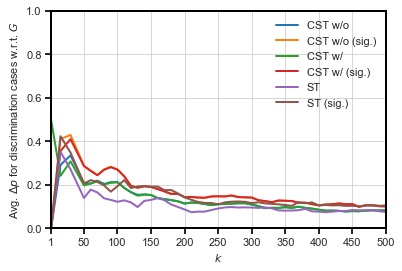

In [6]:
plt.plot(g_k_results['k'], g_k_results['CSTwo_delta'], label='CST w/o')
plt.plot(g_k_results['k'], g_k_results['CSTwo_delta_sig'], label='CST w/o (sig.)')
plt.plot(g_k_results['k'], g_k_results['CSTwi_delta'], label='CST w/')
plt.plot(g_k_results['k'], g_k_results['CSTwi_delta_sig'], label='CST w/ (sig.)')
plt.plot(g_k_results['k'], g_k_results['ST_delta'], label='ST')
plt.plot(g_k_results['k'], g_k_results['ST_delta_sig'], label='ST (sig.)')
plt.xlim(K_l, k_u)
plt.xticks(x_axis)
plt.xlabel("$k$")
plt.ylim(0.0, 1.0)
plt.ylabel("Avg. $\Delta p$ for discrimination cases w.r.t. $G$")
# plt.axvline(x=250, linestyle='--', color='black') #, label='$k=250$')
plt.legend(loc='upper right', ncol=1, fancybox=True)
plt.savefig(os.path.join(figu_path, 'G_all_delta_versus_k.png'), dpi=300, bbox_inches='tight')
plt.show()

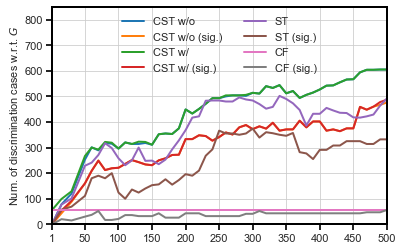

In [7]:
plt.plot(g_k_results['k'], g_k_results['CSTwo'], label='CST w/o')
plt.plot(g_k_results['k'], g_k_results['CSTwo_sig'], label='CST w/o (sig.)')
plt.plot(g_k_results['k'], g_k_results['CSTwi'], label='CST w/')
plt.plot(g_k_results['k'], g_k_results['CSTwi_sig'], label='CST w/ (sig.)')
plt.plot(g_k_results['k'], g_k_results['ST'], label='ST')
plt.plot(g_k_results['k'], g_k_results['ST_sig'], label='ST (sig.)')
plt.plot(g_k_results['k'], g_k_results['CF'], label='CF')
plt.plot(g_k_results['k'], g_k_results['CF_sig'], label='CF (sig.)')
plt.xlim(K_l, k_u)
plt.xticks(x_axis)
plt.ylim(0, 850) #g_k_results.iloc[-1].max() + 15)
# plt.ylim(k_results.iloc[0].min() - 5, k_results.iloc[-1].max() + 5)
# plt.axvline(x=250, linestyle='--', color='black') #, label='$k=250$')
plt.ylabel("Num. of discrimination cases w.r.t. $G$")
plt.legend(loc='upper center', ncol=2, fancybox=True)
# plt.title('CST w/o vs ST')
plt.savefig(os.path.join(figu_path, 'G_all_nums_versus_k.png'), dpi=300, bbox_inches='tight')
plt.show()

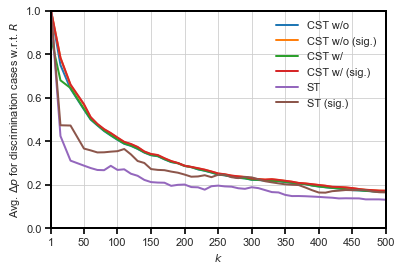

In [8]:
plt.plot(r_k_results['k'], r_k_results['CSTwo_delta'], label='CST w/o')
plt.plot(r_k_results['k'], r_k_results['CSTwo_delta_sig'], label='CST w/o (sig.)')
plt.plot(r_k_results['k'], r_k_results['CSTwi_delta'], label='CST w/')
plt.plot(r_k_results['k'], r_k_results['CSTwi_delta_sig'], label='CST w/ (sig.)')
plt.plot(r_k_results['k'], r_k_results['ST_delta'], label='ST')
plt.plot(r_k_results['k'], r_k_results['ST_delta_sig'], label='ST (sig.)')
plt.xlim(K_l, k_u)
plt.xticks(x_axis)
plt.xlabel("$k$")
plt.ylim(0.0, 1.0)
plt.ylabel("Avg. $\Delta p$ for discrimination cases w.r.t. $R$")
# plt.axvline(x=250, linestyle='--', color='black') #, label='$k=250$')
plt.legend(loc='upper right', ncol=1, fancybox=True)
plt.savefig(os.path.join(figu_path, 'R_all_delta_versus_k.png'), dpi=300, bbox_inches='tight')
plt.show()

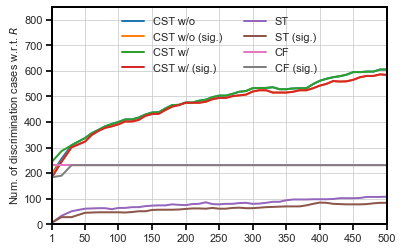

In [9]:
plt.plot(r_k_results['k'], r_k_results['CSTwo'], label='CST w/o')
plt.plot(r_k_results['k'], r_k_results['CSTwo_sig'], label='CST w/o (sig.)')
plt.plot(r_k_results['k'], r_k_results['CSTwi'], label='CST w/')
plt.plot(r_k_results['k'], r_k_results['CSTwi_sig'], label='CST w/ (sig.)')
plt.plot(r_k_results['k'], r_k_results['ST'], label='ST')
plt.plot(r_k_results['k'], r_k_results['ST_sig'], label='ST (sig.)')
plt.plot(r_k_results['k'], r_k_results['CF'], label='CF')
plt.plot(r_k_results['k'], r_k_results['CF_sig'], label='CF (sig.)')
plt.xlim(K_l, k_u)
plt.xticks(x_axis)
plt.ylim(0, 850) #g_k_results.iloc[-1].max() + 15)
# plt.ylim(k_results.iloc[0].min() - 5, k_results.iloc[-1].max() + 5)
# plt.axvline(x=250, linestyle='--', color='black') #, label='$k=250$')
plt.ylabel("Num. of discrimination cases w.r.t. $R$")
plt.legend(loc='upper center', ncol=2, fancybox=True)
# plt.title('CST w/o vs ST')
plt.savefig(os.path.join(figu_path, 'R_all_nums_versus_k.png'), dpi=300, bbox_inches='tight')
plt.show()

### Multiple discrimination

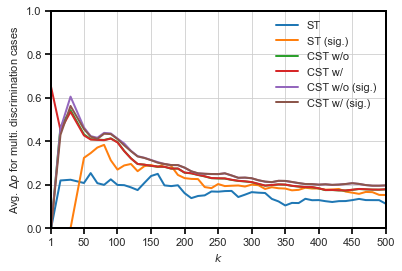

In [10]:
plt.plot(multi_k_results['k'], multi_k_results['ST_delta'], label='ST')
plt.plot(multi_k_results['k'], multi_k_results['ST_delta_sig'], label='ST (sig.)')
plt.plot(multi_k_results['k'], multi_k_results['CSTwo_delta'], label='CST w/o')
plt.plot(multi_k_results['k'], multi_k_results['CSTwi_delta'], label='CST w/')
plt.plot(multi_k_results['k'], multi_k_results['CSTwo_delta_sig'], label='CST w/o (sig.)')
plt.plot(multi_k_results['k'], multi_k_results['CSTwi_delta_sig'], label='CST w/ (sig.)')
plt.xlim(K_l, k_u)
plt.xticks(x_axis)
plt.xlabel("$k$")
plt.ylim(0.0, 1.0)
plt.ylabel("Avg. $\Delta p$ for multi. discrimination cases")
# plt.axvline(x=250, linestyle='--', color='black')
# plt.legend(loc='upper center', ncol=2, fancybox=True)
plt.legend()
plt.savefig(os.path.join(figu_path, 'Multi_all_deltas_versus_k.png'), dpi=300, bbox_inches='tight')
plt.show()

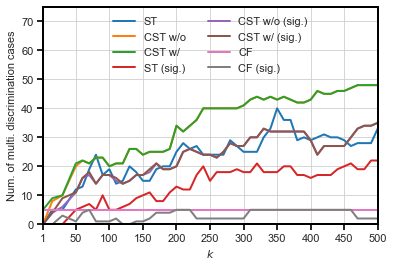

In [11]:
plt.plot(multi_k_results['k'], multi_k_results['ST'], label='ST')
plt.plot(multi_k_results['k'], multi_k_results['CSTwo'], label='CST w/o')
plt.plot(multi_k_results['k'], multi_k_results['CSTwi'], label='CST w/')
plt.plot(multi_k_results['k'], multi_k_results['ST_sig'], label='ST (sig.)')
plt.plot(multi_k_results['k'], multi_k_results['CSTwo_sig'], label='CST w/o (sig.)')
plt.plot(multi_k_results['k'], multi_k_results['CSTwi_sig'], label='CST w/ (sig.)')
plt.plot(multi_k_results['k'], multi_k_results['CF'], label='CF')
plt.plot(multi_k_results['k'], multi_k_results['CF_sig'], label='CF (sig.)')
plt.xlim(K_l, k_u)
plt.xticks(x_axis)
plt.xlabel("$k$")
plt.ylim(0, 75) #multi_k_results.iloc[-1].max() + 15)
plt.ylabel("Num. of multi. discrimination cases")
# plt.axvline(x=250, linestyle='--', color='black')
plt.legend(loc='upper center', ncol=2, fancybox=True)
# plt.legend()
plt.savefig(os.path.join(figu_path, 'Multi_all_nums_versus_k.png'), dpi=300, bbox_inches='tight')
plt.show()

### Intersectional discrimination

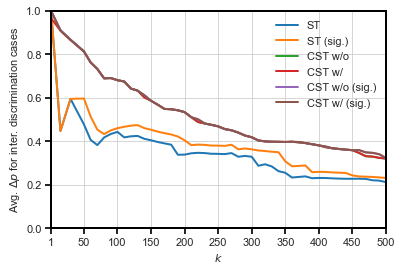

In [12]:
plt.plot(inter_k_results['k'], inter_k_results['ST_delta'], label='ST')
plt.plot(inter_k_results['k'], inter_k_results['ST_delta_sig'], label='ST (sig.)')
plt.plot(inter_k_results['k'], inter_k_results['CSTwo_delta'], label='CST w/o')
plt.plot(inter_k_results['k'], inter_k_results['CSTwi_delta'], label='CST w/')
plt.plot(inter_k_results['k'], inter_k_results['CSTwo_delta_sig'], label='CST w/o (sig.)')
plt.plot(inter_k_results['k'], inter_k_results['CSTwi_delta_sig'], label='CST w/ (sig.)')
plt.xlim(K_l, k_u)
plt.xticks(x_axis)
plt.xlabel("$k$")
plt.ylim(0.0, 1.0)
plt.ylabel("Avg. $\Delta p$ for inter. discrimination cases")
# plt.axvline(x=250, linestyle='--', color='black')
plt.legend()
plt.savefig(os.path.join(figu_path, 'Inter_all_deltas_versus_k.png'), dpi=300, bbox_inches='tight')
plt.show()

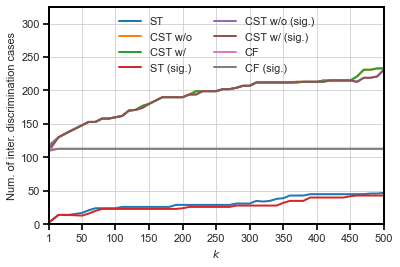

In [13]:
plt.plot(inter_k_results['k'], inter_k_results['ST'], label='ST')
plt.plot(inter_k_results['k'], inter_k_results['CSTwo'], label='CST w/o')
plt.plot(inter_k_results['k'], inter_k_results['CSTwi'], label='CST w/')
plt.plot(inter_k_results['k'], inter_k_results['ST_sig'], label='ST (sig.)')
plt.plot(inter_k_results['k'], inter_k_results['CSTwo_sig'], label='CST w/o (sig.)')
plt.plot(inter_k_results['k'], inter_k_results['CSTwi_sig'], label='CST w/ (sig.)')
plt.plot(inter_k_results['k'], inter_k_results['CF'], label='CF')
plt.plot(inter_k_results['k'], inter_k_results['CF_sig'], label='CF (sig.)')
plt.xlim(K_l, k_u)
plt.xticks(x_axis)
plt.xlabel("$k$")
plt.ylim(0, 325) #inter_k_results.iloc[-1].max() + 15)
plt.ylabel("Num. of inter. discrimination cases")
# plt.axvline(x=250, linestyle='--', color='black')
plt.legend(loc='upper center', ncol=2, fancybox=True)
# plt.legend()
plt.savefig(os.path.join(figu_path, 'Inter_all_nums_versus_k.png'), dpi=300, bbox_inches='tight')
plt.show()

## Summary stats: general and for a given $k$

In [35]:
# load and modify factual data (same for counterfactual data)
org_df = pd.read_csv(data_path + 'clean_LawSchool.csv', sep='|').reset_index(drop=True)
df = org_df[['sex', 'race_nonwhite', 'LSAT', 'UGPA']].copy()
# df['sex'] = df['sex'].map({'Male': 0, 'Female': 1})
# df['race_nonwhite'] = df['race_nonwhite'].map({'White': 0, 'NonWhite': 1})
df.rename(columns={'sex': 'Gender', 'race_nonwhite': 'Race'}, inplace=True)
df.head(5)

,Gender,Race,LSAT,UGPA
0,Female,White,39.0,3.1
1,Female,White,36.0,3.0
2,Male,White,30.0,3.1
3,Male,NonWhite,39.0,2.2
4,Female,White,37.0,3.4


## A 'known' decision maker

An DM based on [the known requirements of US Law Schools](https://schools.lawschoolnumbers.com/). We assume the case for Yale School. We could not find a one-to-one converter between LSAT over 48 to over 180. 173/180 is 96%: it would be about 46.1/48. We assume Yale cuts at these median values, and puts a higher weight on UGPA.

In [36]:
def add_dm(df: pd.DataFrame):
    b1 = 0.6
    b2 = 0.4
    min_score = round(b1 * 3.93 + b2 * 46.1, 2)  # 20.8
    max_score = round(b1 * 4.00 + b2 * 48.00)    # 22
    df['Score'] = b1 * df['UGPA'] + b2 * df['LSAT']
    df['Y'] = np.where(df['Score'] >= min_score, 1, 0)
    return df

In [37]:
df = add_dm(df)
df.head(5)

,Gender,Race,LSAT,UGPA,Score,Y
0,Female,White,39.0,3.1,17.46,0
1,Female,White,36.0,3.0,16.20,0
2,Male,White,30.0,3.1,13.86,0
3,Male,NonWhite,39.0,2.2,16.92,0
4,Female,White,37.0,3.4,16.84,0


## Summary statistics

In [38]:
print('Num. of applicants')
print(df.shape[0])
###
print('Females')
print(df[df['Gender'] == 'Female'].shape[0])
print(df[df['Gender'] == 'Female'].shape[0] / df.shape[0] * 100)
###
print('Non-whites')
print(df[df['Race'] == 'NonWhite'].shape[0])
print(df[df['Race'] == 'NonWhite'].shape[0] / df.shape[0] * 100)
###
print('Female-non-whites')
print(df[(df['Gender'] == 'Female') & (df['Race'] == 'NonWhite')].shape[0])
print(df[(df['Gender'] == 'Female') & (df['Race'] == 'NonWhite')].shape[0] / df.shape[0] * 100)

Num. of applicants
21790
Females
9537
43.76778338687471
Non-whites
3506
16.08994951812758
Female-non-whites
1833
8.41211564938045


In [39]:
print('Num. of accepted applicants')
print(df[df['Y'] == 1].shape[0])
print(df[df['Y'] == 1].shape[0] / df.shape[0] * 100)
###
print('Females')
print(df[(df['Y'] == 1) & (df['Gender'] == 'Female')].shape[0])
print(df[(df['Y'] == 1) & (df['Gender'] == 'Female')].shape[0] / df.shape[0] * 100)
print('Males')
print(df[(df['Y'] == 1) & (df['Gender'] == 'Male')].shape[0])
print(df[(df['Y'] == 1) & (df['Gender'] == 'Male')].shape[0] / df.shape[0] * 100)
###
print('Non-whites')
print(df[(df['Y'] == 1) & (df['Race'] == 'NonWhite')].shape[0])
print(df[(df['Y'] == 1) & (df['Race'] == 'NonWhite')].shape[0] / df.shape[0] * 100)
print('Whites')
print(df[(df['Y'] == 1) & (df['Race'] == 'White')].shape[0])
print(df[(df['Y'] == 1) & (df['Race'] == 'White')].shape[0] / df.shape[0] * 100)
###
print('Female-non-whites')
print(df[(df['Y'] == 1) & (df['Gender'] == 'Female') & (df['Race'] == 'NonWhite')].shape[0])
print(df[(df['Y'] == 1) & (df['Gender'] == 'Female') & (df['Race'] == 'NonWhite')].shape[0] / df.shape[0] * 100)
print('All but female-non-whites')
tot = df[(df['Y'] == 1) & (df['Gender'] == 'Female') & (df['Race'] == 'White')].shape[0] + df[(df['Y'] == 1) & (df['Gender'] == 'Male') & (df['Race'] == 'NonWhite')].shape[0] + df[(df['Y'] == 1) & (df['Gender'] == 'Male') & (df['Race'] == 'White')].shape[0]
print(tot)
print(tot / df.shape[0] * 100)


Num. of accepted applicants
505
2.31757687012391
Females
180
0.8260670032124828
Males
325
1.4915098669114273
Non-whites
33
0.15144561725562183
Whites
472
2.166131252868288
Female-non-whites
14
0.06424965580541532
All but female-non-whites
491
2.2533272143184946


## Parameters for the analysis (CST w/o)

In [46]:
# --- general setup
k = 15
alpha = 0.05
tau = 0.0
# --- same attributes for prot. att. cases (read, "do")
feat_trgt = 'Y'
feat_trgt_vals = {'positive': 1, 'negative': 0}
feat_rlvt = ['LSAT', 'UGPA']

### Single discrimination: $G$

In [85]:
# --- specific attributes
do = 'Male'
feat_prot = 'Gender'
feat_prot_vals = {'non_protected': 'Male', 'protected': 'Female'}
# --- load the counterfactuals
org_cf_df = pd.read_csv(data_path + os.sep + 'counterfactuals' + os.sep + f'cf_LawSchool_lev3_do{do}.csv', sep='|').reset_index(drop=True)
g_cf_df = org_cf_df[['Sex', 'Race', 'scf_LSAT', 'scf_UGPA']].copy()
g_cf_df = g_cf_df.rename(columns={'Sex': 'Gender', 'scf_LSAT': 'LSAT', 'scf_UGPA': 'UGPA'})
g_cf_df = add_dm(g_cf_df)
g_cf_df.head(5)

,Gender,Race,LSAT,UGPA,Score,Y
0,Female,White,39.609,2.975,17.6286,0
1,Female,White,36.609,2.875,16.3686,0
2,Male,White,30.000,3.100,13.8600,0
3,Male,NonWhite,39.000,2.200,16.9200,0
4,Female,White,37.609,3.275,17.0086,0


In [86]:
# update the inputs (where needed)
test_df    = df.copy()
test_cf_df = g_cf_df.copy()
# run the method
g_cst = SituationTesting()
g_cst.setup_baseline(test_df, test_cf_df, nominal_atts=['Gender'], continuous_atts=['LSAT', 'UGPA'])
g_cst.run(
    target_att=feat_trgt, target_val=feat_trgt_vals, sensitive_att=feat_prot, sensitive_val=feat_prot_vals, include_centers=False, k=k, alpha=alpha, tau=tau
)
# get discrimination results
res_g_cst = g_cst.get_test_discrimination()
res_g_cst.head(5)

,individual,p_c,p_t,delta_p,CI_1st,CI_2st,DiscEvi,StatEvi
0,0,1.0,1.0,0.0,0.0,"[0.0, 0.0]",No,No
1,1,1.0,1.0,0.0,0.0,"[0.0, 0.0]",No,No
2,4,1.0,1.0,0.0,0.0,"[0.0, 0.0]",No,No
3,5,1.0,1.0,0.0,0.0,"[0.0, 0.0]",No,No
4,8,1.0,1.0,0.0,0.0,"[0.0, 0.0]",No,No


### Single discrimination $R$

In [87]:
# --- specific attributes
do = 'White'
feat_prot = 'Race'
feat_prot_vals = {'non_protected': 'White', 'protected': 'NonWhite'}
# --- load the counterfactuals
org_cf_df = pd.read_csv(data_path + os.sep + 'counterfactuals' + os.sep + f'cf_LawSchool_lev3_do{do}.csv', sep='|').reset_index(drop=True)
r_cf_df = org_cf_df[['Sex', 'Race', 'scf_LSAT', 'scf_UGPA']].copy()
r_cf_df = r_cf_df.rename(columns={'Sex': 'Gender', 'scf_LSAT': 'LSAT', 'scf_UGPA': 'UGPA'})
r_cf_df = add_dm(r_cf_df)
r_cf_df.head(5)

,Gender,Race,LSAT,UGPA,Score,Y
0,Female,White,39.000,3.100,17.460,0
1,Female,White,36.000,3.000,16.200,0
2,Male,White,30.000,3.100,13.860,0
3,Male,NonWhite,43.639,2.419,18.907,0
4,Female,White,37.000,3.400,16.840,0


In [88]:
# update the inputs (where needed)
test_df    = df.copy()
test_cf_df = r_cf_df.copy()
# run the method
r_cst = SituationTesting()
r_cst.setup_baseline(test_df, test_cf_df, nominal_atts=['Race'], continuous_atts=['LSAT', 'UGPA'])
r_cst.run(
    target_att=feat_trgt, target_val=feat_trgt_vals, sensitive_att=feat_prot, sensitive_val=feat_prot_vals, include_centers=False, k=k, alpha=alpha, tau=tau
)
# get discrimination results
res_r_cst = r_cst.get_test_discrimination()
res_r_cst.head(5)

,individual,p_c,p_t,delta_p,CI_1st,CI_2st,DiscEvi,StatEvi
0,3,1.0,1.0,0.0,0.0,"[0.0, 0.0]",No,No
1,23,1.0,1.0,0.0,0.0,"[0.0, 0.0]",No,No
2,25,1.0,1.0,0.0,0.0,"[0.0, 0.0]",No,No
3,41,1.0,1.0,0.0,0.0,"[0.0, 0.0]",No,No
4,44,1.0,1.0,0.0,0.0,"[0.0, 0.0]",No,No


### Multiple discrimination: $G + R$

In [89]:
print('females:')
print(sum(res_g_cst['DiscEvi'] == 'Yes'))
print('non-whites:')
print(sum(res_r_cst['DiscEvi'] == 'Yes'))
print('females and non-whites:')
res_multi_cst = pd.merge(
        res_g_cst[res_g_cst['DiscEvi'] == 'Yes'], res_r_cst[res_r_cst['DiscEvi'] == 'Yes'], how='inner', on='individual'
    )
print(res_multi_cst.shape[0])

females:
78
non-whites:
243
females and non-whites:
8


In [90]:
ind_multi = res_multi_cst['individual'].to_list() 
len(ind_multi)

8

### Intersectional discrimination: $G \cap R$

In [91]:
# --- specific attributes
do = 'MaleWhite'
feat_prot = 'GenderRace'

feat_prot_vals = {'non_protected': ['Female-White', 'Male-NonWhite', 'Male-NonWhite', 'Male-White'], 
                  'protected': 'Female-NonWhite'
                 }
# --- load the counterfactuals
org_cf_df = pd.read_csv(data_path + os.sep + 'counterfactuals' + os.sep + f'cf_LawSchool_lev3_do{do}.csv', sep='|').reset_index(drop=True)
i_cf_df = org_cf_df[['GenderRace', 'scf_LSAT', 'scf_UGPA']].copy()
i_cf_df = i_cf_df.rename(columns={'scf_LSAT': 'LSAT', 'scf_UGPA': 'UGPA'})
i_cf_df = add_dm(i_cf_df)
i_cf_df.head(5)

,GenderRace,LSAT,UGPA,Score,Y
0,Female-White,39.0,3.1,17.46,0
1,Female-White,36.0,3.0,16.20,0
2,Male-White,30.0,3.1,13.86,0
3,Male-NonWhite,39.0,2.2,16.92,0
4,Female-White,37.0,3.4,16.84,0


In [92]:
# Note: updated the factuals also to obtain A*
df['GenderRace'] =  df['Gender'] + '-' + df['Race']
df.head(5)

,Gender,Race,LSAT,UGPA,Score,Y,GenderRace
0,Female,White,39.0,3.1,17.46,0,Female-White
1,Female,White,36.0,3.0,16.20,0,Female-White
2,Male,White,30.0,3.1,13.86,0,Male-White
3,Male,NonWhite,39.0,2.2,16.92,0,Male-NonWhite
4,Female,White,37.0,3.4,16.84,0,Female-White


In [93]:
# update the inputs (where needed)
test_df    = df.copy()
test_cf_df = i_cf_df.copy()
# run the method
inter_cst = SituationTesting()
inter_cst.setup_baseline(test_df, test_cf_df, nominal_atts=['GenderRace'], continuous_atts=['LSAT', 'UGPA'])
inter_cst.run(
    target_att=feat_trgt, target_val=feat_trgt_vals, sensitive_att=feat_prot, sensitive_val=feat_prot_vals, include_centers=False, k=k, alpha=alpha, tau=tau
)
# get discrimination results
res_inter_cst = inter_cst.get_test_discrimination()
res_inter_cst.head(5)

,individual,p_c,p_t,delta_p,CI_1st,CI_2st,DiscEvi,StatEvi
0,41,1.0,1.0,0.0,0.0,"[0.0, 0.0]",No,No
1,44,1.0,1.0,0.0,0.0,"[0.0, 0.0]",No,No
2,54,1.0,1.0,0.0,0.0,"[0.0, 0.0]",No,No
3,62,1.0,1.0,0.0,0.0,"[0.0, 0.0]",No,No
4,79,1.0,1.0,0.0,0.0,"[0.0, 0.0]",No,No


In [94]:
ind_inter = res_inter_cst[res_inter_cst['DiscEvi'] == 'Yes']['individual'].to_list() 
len(ind_inter)

130

### Comparing the two kinds of multidimensional discrimination

In [95]:
knn_r_cst     = r_cst.res_dict_df_neighbors
knn_g_cst     = g_cst.res_dict_df_neighbors
knn_inter_cst = inter_cst.res_dict_df_neighbors

In [96]:
# are all multi cases in the inter cases?
len([i for i in ind_multi if i in ind_inter]) == len(res_multi_cst)

True

In [107]:
# individuals in multi and inter
set1 = ind_multi
# individuals only in inter
set2 = [i for i in ind_inter if i not in ind_multi]

In [113]:
set_of_interest = set1
nsf = 2
n = k
list_temp_df = []
var = ['LSAT', 'UGPA', 'Y']

for c in set_of_interest:
    
    temp_df = {}
    
    temp_df['id'] = c
    
    # for gender
    g_temp_ctr = df.iloc[knn_g_cst[c]['ctr_idx'], :][var]
    g_temp_tst = g_cf_df.iloc[knn_g_cst[c]['tst_idx'], :][var]
    # for race
    r_temp_ctr = df.iloc[knn_r_cst[c]['ctr_idx'], :][var]
    r_temp_tst = r_cf_df.iloc[knn_r_cst[c]['tst_idx'], :][var]
    # for inter
    i_temp_ctr = df.iloc[knn_inter_cst[c]['ctr_idx'], :][var]
    i_temp_tst = i_cf_df.iloc[knn_inter_cst[c]['tst_idx'], :][var]
    
    # num. of negative decisions
    temp_df['g_neg_y_ctr'] = g_temp_ctr[g_temp_ctr['Y'] == 0].shape[0]
    temp_df['g_neg_y_tst'] = g_temp_tst[g_temp_tst['Y'] == 0].shape[0]
    temp_df['r_neg_y_ctr'] = r_temp_ctr[r_temp_ctr['Y'] == 0].shape[0]
    temp_df['r_neg_y_tst'] = r_temp_tst[r_temp_tst['Y'] == 0].shape[0]
    temp_df['i_neg_y_ctr'] = i_temp_ctr[i_temp_ctr['Y'] == 0].shape[0]
    temp_df['i_neg_y_tst'] = i_temp_tst[i_temp_tst['Y'] == 0].shape[0]
    
    # prp. of negative decisions
    temp_df['g_p_ctr'] = round(temp_df['g_neg_y_ctr'] / n, nsf)
    temp_df['g_p_tst'] = round(temp_df['g_neg_y_tst'] / n, nsf)
    temp_df['r_p_ctr'] = round(temp_df['r_neg_y_ctr'] / n, nsf)
    temp_df['r_p_tst'] = round(temp_df['r_neg_y_tst'] / n, nsf)
    temp_df['i_p_ctr'] = round(temp_df['i_neg_y_ctr'] / n, nsf)
    temp_df['i_p_tst'] = round(temp_df['i_neg_y_tst'] / n, nsf)
    
    # group characteristics
    for v in ['LSAT', 'UGPA']:
        temp_df['g_avg_ctr' + v] = round(g_temp_ctr.mean()[v], nsf)
        temp_df['g_std_ctr' + v] = round(g_temp_ctr.std()[v], nsf)
        temp_df['r_avg_ctr' + v] = round(r_temp_ctr.mean()[v], nsf)
        temp_df['r_std_ctr' + v] = round(r_temp_ctr.std()[v], nsf)
        temp_df['i_avg_ctr' + v] = round(i_temp_ctr.mean()[v], nsf)
        temp_df['i_std_ctr' + v] = round(i_temp_ctr.std()[v], nsf)
        temp_df['g_avg_tst' + v] = round(g_temp_tst.mean()[v], nsf)
        temp_df['g_std_tst' + v] = round(g_temp_tst.std()[v], nsf)
        temp_df['r_avg_tst' + v] = round(r_temp_tst.mean()[v], nsf)
        temp_df['r_std_tst' + v] = round(r_temp_tst.std()[v], nsf)
        temp_df['i_avg_tst' + v] = round(i_temp_tst.mean()[v], nsf)
        temp_df['i_std_tst' + v] = round(i_temp_tst.std()[v], nsf)
    
    list_temp_df.append(temp_df)

summary_stats = pd.DataFrame(list_temp_df)
summary_stats.mean().round(nsf)

id               11597.12
g_neg_y_ctr          8.88
g_neg_y_tst          4.88
r_neg_y_ctr          7.62
r_neg_y_tst          0.00
i_neg_y_ctr         10.00
i_neg_y_tst          0.00
g_p_ctr              0.59
g_p_tst              0.33
r_p_ctr              0.51
r_p_tst              0.00
i_p_ctr              0.66
i_p_tst              0.00
g_avg_ctrLSAT       46.66
g_std_ctrLSAT        0.45
r_avg_ctrLSAT       46.58
r_std_ctrLSAT        0.91
i_avg_ctrLSAT       46.08
i_std_ctrLSAT        1.25
g_avg_tstLSAT       47.06
g_std_tstLSAT        0.16
r_avg_tstLSAT       48.00
r_std_tstLSAT        0.00
i_avg_tstLSAT       47.95
i_std_tstLSAT        0.06
g_avg_ctrUGPA        3.55
g_std_ctrUGPA        0.00
r_avg_ctrUGPA        3.54
r_std_ctrUGPA        0.06
i_avg_ctrUGPA        3.52
i_std_ctrUGPA        0.10
g_avg_tstUGPA        3.45
g_std_tstUGPA        0.00
r_avg_tstUGPA        3.73
r_std_tstUGPA        0.01
i_avg_tstUGPA        3.65
i_std_tstUGPA        0.00
dtype: float64

In [114]:
set_of_interest = set2
nsf = 2
n = k
list_temp_df = []
var = ['LSAT', 'UGPA', 'Y']

for c in set_of_interest:
    
    temp_df = {}
    
    temp_df['id'] = c
    
    # for gender
    g_temp_ctr = df.iloc[knn_g_cst[c]['ctr_idx'], :][var]
    g_temp_tst = g_cf_df.iloc[knn_g_cst[c]['tst_idx'], :][var]
    # for race
    r_temp_ctr = df.iloc[knn_r_cst[c]['ctr_idx'], :][var]
    r_temp_tst = r_cf_df.iloc[knn_r_cst[c]['tst_idx'], :][var]
    # for inter
    i_temp_ctr = df.iloc[knn_inter_cst[c]['ctr_idx'], :][var]
    i_temp_tst = i_cf_df.iloc[knn_inter_cst[c]['tst_idx'], :][var]
    
    # num. of negative decisions
    temp_df['g_neg_y_ctr'] = g_temp_ctr[g_temp_ctr['Y'] == 0].shape[0]
    temp_df['g_neg_y_tst'] = g_temp_tst[g_temp_tst['Y'] == 0].shape[0]
    temp_df['r_neg_y_ctr'] = r_temp_ctr[r_temp_ctr['Y'] == 0].shape[0]
    temp_df['r_neg_y_tst'] = r_temp_tst[r_temp_tst['Y'] == 0].shape[0]
    temp_df['i_neg_y_ctr'] = i_temp_ctr[i_temp_ctr['Y'] == 0].shape[0]
    temp_df['i_neg_y_tst'] = i_temp_tst[i_temp_tst['Y'] == 0].shape[0]
    
    # prp. of negative decisions
    temp_df['g_p_ctr'] = round(temp_df['g_neg_y_ctr'] / n, nsf)
    temp_df['g_p_tst'] = round(temp_df['g_neg_y_tst'] / n, nsf)
    temp_df['r_p_ctr'] = round(temp_df['r_neg_y_ctr'] / n, nsf)
    temp_df['r_p_tst'] = round(temp_df['r_neg_y_tst'] / n, nsf)
    temp_df['i_p_ctr'] = round(temp_df['i_neg_y_ctr'] / n, nsf)
    temp_df['i_p_tst'] = round(temp_df['i_neg_y_tst'] / n, nsf)
    
    # group characteristics
    for v in ['LSAT', 'UGPA']:
        temp_df['g_avg_ctr' + v] = round(g_temp_ctr.mean()[v], nsf)
        temp_df['g_std_ctr' + v] = round(g_temp_ctr.std()[v], nsf)
        temp_df['r_avg_ctr' + v] = round(r_temp_ctr.mean()[v], nsf)
        temp_df['r_std_ctr' + v] = round(r_temp_ctr.std()[v], nsf)
        temp_df['i_avg_ctr' + v] = round(i_temp_ctr.mean()[v], nsf)
        temp_df['i_std_ctr' + v] = round(i_temp_ctr.std()[v], nsf)
        temp_df['g_avg_tst' + v] = round(g_temp_tst.mean()[v], nsf)
        temp_df['g_std_tst' + v] = round(g_temp_tst.std()[v], nsf)
        temp_df['r_avg_tst' + v] = round(r_temp_tst.mean()[v], nsf)
        temp_df['r_std_tst' + v] = round(r_temp_tst.std()[v], nsf)
        temp_df['i_avg_tst' + v] = round(i_temp_tst.mean()[v], nsf)
        temp_df['i_std_tst' + v] = round(i_temp_tst.std()[v], nsf)
    
    list_temp_df.append(temp_df)

summary_stats = pd.DataFrame(list_temp_df)
summary_stats.mean().round(nsf)

id               11099.51
g_neg_y_ctr         14.42
g_neg_y_tst         14.03
r_neg_y_ctr         14.02
r_neg_y_tst          3.47
i_neg_y_ctr         14.01
i_neg_y_tst          0.10
g_p_ctr              0.96
g_p_tst              0.94
r_p_ctr              0.93
r_p_tst              0.23
i_p_ctr              0.93
i_p_tst              0.01
g_avg_ctrLSAT       43.90
g_std_ctrLSAT        0.14
r_avg_ctrLSAT       43.68
r_std_ctrLSAT        0.72
i_avg_ctrLSAT       43.55
i_std_ctrLSAT        0.96
g_avg_tstLSAT       43.94
g_std_tstLSAT        0.06
r_avg_tstLSAT       47.48
r_std_tstLSAT        0.04
i_avg_tstLSAT       47.71
i_std_tstLSAT        0.04
g_avg_ctrUGPA        3.47
g_std_ctrUGPA        0.00
r_avg_ctrUGPA        3.47
r_std_ctrUGPA        0.03
i_avg_ctrUGPA        3.47
i_std_ctrUGPA        0.06
g_avg_tstUGPA        3.38
g_std_tstUGPA        0.00
r_avg_tstUGPA        3.66
r_std_tstUGPA        0.01
i_avg_tstUGPA        3.58
i_std_tstUGPA        0.01
dtype: float64

In [ ]:
# # add the decision maker
# cf_df['Score'] = b1*cf_df['UGPA'] + b2*cf_df['LSAT']
# cf_df['Y'] = np.where(cf_df['Score'] >= min_score, 1, 0)
# cf_df.head(5)

# # old code example: we output the pd.Series of delta p's for situation testing
# m_res_df = df[['Gender', 'Race', 'Y']].copy()
# m_res_df['cf_Y'] = cf_df[['Y']].copy()
# m_res_df.head(5)
# test_df = df.copy()
# st = SituationTesting()
# st.setup_baseline(test_df, nominal_atts=['Gender'], continuous_atts=['LSAT', 'UGPA'])
# m_res_df['stST'] = st.run(target_att=feat_trgt, target_val=feat_trgt_vals, sensitive_att=feat_prot, sensitive_val=feat_prot_vals, k=n, alpha=alpha, tau=tau)
# m_res_df[(m_res_df['stST'] > tau)].shape[0]
# # positive discrimination?
# m_res_df[(m_res_df['stST'] < tau)].shape[0]